In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns

import df_visualizations as dv
import remap_values as rv

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn               import linear_model

In [2]:
%matplotlib inline
plt.style.use( 'dark_background' )
plt.rcParams['figure.figsize'] = (14,10)

In [3]:
use_list = ['parcelid',
    'logerror','transactiondate','airconditioningtypeid','pooltypeid10', # Hotub
    'poolsizesum','garagetotalsqft','calculatedbathnbr','fireplacecnt',
    'finishedsquarefeet12','lotsizesquarefeet','taxdelinquencyflag','yearbuilt',
    'structuretaxvaluedollarcnt','taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount',
    'decktypeid','numberofstories','buildingqualitytypeid','unitcnt','roomcnt' ]

In [13]:
prop  = pd.read_csv( 'data/properties_2016.csv' )
trans = pd.read_csv( 'data/train_2016_v2.csv'   )

my_df = pd.merge( prop, trans, on='parcelid', how='inner' )
my_df = my_df[ use_list ]

del prop
del trans

my_df['transactiondate' ] =   pd.to_datetime  ( my_df['transactiondate'] )
my_df['time_since_built'] = ( pd.DatetimeIndex( my_df['transactiondate'] ).year - my_df['yearbuilt'] )
my_df['ordinal_date'    ] =  [x.toordinal() for x in my_df['transactiondate']]
my_df['day_of_week'     ] = ( my_df['ordinal_date'] - my_df['ordinal_date'].min() + 2 ) % 7

my_df['time_since_built'] = my_df['time_since_built'].fillna( my_df['time_since_built'].median() )

my_df = my_df.drop( ['yearbuilt'], axis=1 )

print my_df.shape




# Only flag which units have AC

my_df['has_ac'] = 1

my_df.ix[ my_df['airconditioningtypeid'].isnull(), ['has_ac'] ] = 0
my_df.ix[ my_df['airconditioningtypeid'] == 5    , ['has_ac'] ] = 0

my_df = my_df.drop( 'airconditioningtypeid', axis=1 )




# Flag for has pool, has spa, size of pool

my_df['has_spa'  ] = 0
my_df['has_pool' ] = 0
my_df['pool_sqft'] = 0

my_df['has_spa'  ] = my_df['pooltypeid10'].fillna(0).astype(int)
my_df['pool_sqft'] = my_df['poolsizesum' ].fillna(0)
my_df['has_pool' ] =(my_df['poolsizesum' ] > 0).astype(int)

my_df = my_df.drop( ['pooltypeid10','poolsizesum'], axis=1 )




# Save the sqft in better variables

my_df['unit_sqft'] = my_df['finishedsquarefeet12']
my_df[ 'lot_sqft'] = my_df['lotsizesquarefeet'   ].fillna( my_df['lotsizesquarefeet'].median() )

my_df = my_df.drop( ['finishedsquarefeet12', 'lotsizesquarefeet'], axis=1 )






# n_units, if nan most likely a single unit. 1/nan, 2, 3, 4, multi

my_df['unitcnt'].unique()

my_df['unit_single'] = 0
my_df['unit_double'] = 0
my_df['unit_multi' ] = 0

my_df.ix[ my_df['unitcnt'].isnull() , 'unit_single' ] = 1
my_df.ix[ my_df['unitcnt'] == 1     , 'unit_single' ] = 1
my_df.ix[ my_df['unitcnt'] == 2     , 'unit_double' ] = 1
my_df.ix[ my_df['unitcnt'] >  2     , 'unit_multi'  ] = 1

my_df = my_df.drop( 'unitcnt', axis=1 )





# Flag for tax delinquency

my_df['tax_delinquent'] = my_df['taxdelinquencyflag'].fillna(0).replace( {'Y': 1} )

my_df = my_df.drop( 'taxdelinquencyflag', axis=1 )





# Break building quality into categories

my_df['building_quality_low' ] = 0
my_df['building_quality_med' ] = 0
my_df['building_quality_high'] = 0
my_df['building_quality_unkn'] = 0

my_df.ix[  my_df['buildingqualitytypeid'] < 4     , 'building_quality_high' ] = 1
my_df.ix[  my_df['buildingqualitytypeid'] > 8     , 'building_quality_low'  ] = 1
my_df.ix[ (my_df['buildingqualitytypeid'] > 3)    &
        (  my_df['buildingqualitytypeid'] < 9)    , 'building_quality_med'  ] = 1
my_df.ix[  my_df['buildingqualitytypeid'].isnull(), 'building_quality_unkn' ] = 1

my_df = my_df.drop( 'buildingqualitytypeid', axis=1 )





# Have flag for garage, and sqft variable

my_df['has_garage' ] = 0
my_df['garage_sqft'] = my_df['garagetotalsqft'].fillna(0)

my_df.ix[ my_df['garagetotalsqft']>1, 'has_garage' ] = 1

my_df = my_df.drop( 'garagetotalsqft', axis=1 )






# Break into single, multi-story flag

my_df['story_single'] = 0
my_df['story_multi' ] = 0
my_df['story_unkn'  ] = 0

my_df.ix[ my_df['numberofstories'] == 1    , 'story_single' ] = 1
my_df.ix[ my_df['numberofstories'] >  1    , 'story_multi'  ] = 1
my_df.ix[ my_df['numberofstories'].isnull(), 'story_unkn'   ] = 1


my_df = my_df.drop( 'numberofstories', axis=1 )






# 1 hot encode deck, var for number of fireplaces

#my_df['n_fireplaces'] = my_df['fireplacecnt'].fillna(0)
my_df['has_deck'    ] = my_df['decktypeid'  ].notnull().astype(int)

my_df = my_df.drop( ['fireplacecnt','decktypeid'], axis=1 )



# Drop any duplicate rows

my_df = my_df.drop_duplicates( subset='parcelid', keep="last")




# Fill null values in tax info

def regression_taxamount( inp_df ):

    # get values, and log them
    foo = np.log10( inp_df[['taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt']] ).copy()
    foo['parcelid'] = inp_df['parcelid']
    
    # Bar is just not null values, for regression
    bar = foo.dropna()
    
        
    # Perform regressions
    land_reg = linear_model.LinearRegression()
    tax_reg  = linear_model.LinearRegression()
    amt_reg  = linear_model.LinearRegression()
    str_reg  = linear_model.LinearRegression()

    
    land_reg.fit( bar['taxamount'        ].to_frame(), bar['landtaxvaluedollarcnt'].to_frame() )
    tax_reg.fit ( bar['taxamount'        ].to_frame(), bar[    'taxvaluedollarcnt'].to_frame() )
    amt_reg.fit ( bar['taxvaluedollarcnt'].to_frame(), bar[            'taxamount'].to_frame() )
    str_reg.fit ( bar['taxvaluedollarcnt'].to_frame(), bar['structuretaxvaluedollarcnt'].to_frame() )

    # Get the id numbers for the rows with NaN values
    for id_num in foo[ foo.drop( 'structuretaxvaluedollarcnt',axis=1).isnull().any(axis=1) ]['parcelid'].values:
        
        # Find which row it is
        row_num = foo.loc[ foo['parcelid'] == id_num ].index
        
        # Depending on what's missing, fill it in
        
        
        if( foo.ix[ row_num, 'landtaxvaluedollarcnt' ].isnull().values ):
            foo.ix[ row_num, 'landtaxvaluedollarcnt' ] = land_reg.predict( foo.ix[ row_num, 'taxamount'         ].values.reshape(-1,1) )
            
        if( foo.ix[ row_num,     'taxvaluedollarcnt' ].isnull().values ):
            foo.ix[ row_num,     'taxvaluedollarcnt' ] =  tax_reg.predict( foo.ix[ row_num, 'taxamount'         ].values.reshape(-1,1) )
            
        if( foo.ix[ row_num,             'taxamount' ].isnull().values ):
            foo.ix[ row_num,             'taxamount' ] =  amt_reg.predict( foo.ix[ row_num, 'taxvaluedollarcnt' ].values.reshape(-1,1) )

    for id_num in foo[ foo.isnull().any(axis=1) ]['parcelid'].values:

        row_num = foo.loc[ foo['parcelid'] == id_num ].index
        
        if( foo.ix[ row_num,'structuretaxvaluedollarcnt'].isnull().values ):
            foo.ix[ row_num,'structuretaxvaluedollarcnt'] =  tax_reg.predict( foo.ix[ row_num,'taxvaluedollarcnt'].values.reshape(-1,1) )

            
    return foo[['taxamount','taxvaluedollarcnt','landtaxvaluedollarcnt','structuretaxvaluedollarcnt']]
            
foo = regression_taxamount( my_df )

my_df['log_tax_amount'] = foo['taxamount']
my_df['log_tax_value' ] = foo['taxvaluedollarcnt']
my_df['log_land_tax'  ] = foo['landtaxvaluedollarcnt']
my_df['log_str_tax'   ] = foo['structuretaxvaluedollarcnt']

del foo


# Fill in nulls for number of bathrooms

def reg_num_bath( inp_df ):
    
    foo = inp_df[['calculatedbathnbr','structuretaxvaluedollarcnt','parcelid']].copy()
    foo['structuretaxvaluedollarcnt'] = np.log10( foo['structuretaxvaluedollarcnt'] ) 
    foo['calculatedbathnbr'         ] = 2 *       foo['calculatedbathnbr'         ]
    
    bar = foo.dropna()
        
    # Perform regressions
    bath_reg = linear_model.LinearRegression()
    
    bath_reg.fit( bar['structuretaxvaluedollarcnt'].to_frame(), bar['calculatedbathnbr'].to_frame() )
    
    # Don't need to worry about going through rows
    # Locate bad indexes, and fill those spots with predicted values
    null_index = foo.isnull().any(axis=1)

    # Do regression
    foo.ix[ null_index, ['calculatedbathnbr'] ] = \
        bath_reg.predict( foo.ix[ null_index, 'structuretaxvaluedollarcnt' ].values.reshape(-1,1) )
        
    # Convert to 1, 1.5 2 ... baths
    foo        ['calculatedbathnbr'] = foo['calculatedbathnbr'].round()/2.
    
    # Lowst valid is 1
    foo.ix[ foo['calculatedbathnbr'] < 1,  'calculatedbathnbr'] = 1
    
    # Regression only valid for up to 3, VAST majority in this range
    foo.ix[ null_index & (foo.loc[ null_index ]['calculatedbathnbr'] > 3), 'calculatedbathnbr' ] = 3
    
    return foo['calculatedbathnbr']

my_df['structuretaxvaluedollarcnt'] = 10**my_df['log_str_tax']
my_df['n_bath'] = reg_num_bath( my_df )


# Final steps

my_df['n_rooms'] = my_df['roomcnt']


def reg_unit_sqft( inp_df ):

    
    # Only things we need for regression
    foo = inp_df[['unit_sqft','n_bath','log_str_tax']].copy()
    
    foo['unit_sqft'] = np.log10( foo['unit_sqft'] +1 )
    
    # Bar is just not null values, for regression
    bar = foo.dropna()
    
    # Perform regressions
    unit_reg = linear_model.LinearRegression()
    unit_reg.fit( bar[['n_bath','log_str_tax']], bar['unit_sqft'].to_frame() )
    
    
    # Locate bad indexes, and fill those spots with predicted values
    null_index = foo.isnull().any(axis=1)


    # Do regression
    foo.ix[ null_index, ['unit_sqft'] ] = unit_reg.predict( foo.ix[ null_index, ['n_bath','log_str_tax'] ].values )#.reshape(-1,1) )

    return 10**foo['unit_sqft']
    
my_df['unit_sqft'] = reg_unit_sqft( my_df )


def reg_rooms( inp_df ):

    
    # Only things we need for regression
    foo = inp_df[['n_rooms','n_bath','unit_sqft','parcelid']].copy()
    
    foo['unit_sqft'] = np.log10( foo['unit_sqft'] )
    
    
    # Bar is just not null values, for regression
    bar = foo.loc[ foo['n_rooms']>0 ].dropna()
    
    
    # We will attempt to predict the difference between n_rooms, n_bath
    bar['diff'] = bar['n_rooms']-bar['n_bath']

    
    # Perform regressions
    room_reg = linear_model.LinearRegression()
    room_reg.fit( bar['unit_sqft'].to_frame(), bar['n_rooms'].to_frame() )    
    
    # Locate bad indexes, and fill those spots with predicted values
    null_index = foo.isnull().any(axis=1) | ( foo['n_rooms'] < 1 )
    
    
    # Do regression
    foo.ix[ null_index, ['n_rooms'] ] = room_reg.predict( foo.ix[ null_index, 'unit_sqft' ].values.reshape(-1,1) ).round()

    foo['diff'] = foo['n_rooms']-foo['n_bath']
        
    # if n_rooms-6.5 <= diff, n_rooms-6.5 <= n_rooms-n_bath
    foo.ix[ foo['n_rooms']-6.5 > foo['diff'], 'n_rooms' ] = ( foo.loc[ foo['n_rooms']-6.5 > foo['diff'] ]['n_rooms']-6.5 ).round()
    
    foo.ix[ foo['n_rooms']<0, 'n_rooms' ] = foo.ix[ foo['n_rooms']>0, 'n_rooms' ].min()
    
    return foo['n_rooms']
    
my_df['n_rooms'] = reg_rooms( my_df )


my_df = my_df.drop( ['calculatedbathnbr', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 
                     'landtaxvaluedollarcnt', 'taxamount', 'roomcnt', 'transactiondate', 'ordinal_date' ], axis=1 )

(90275, 24)


In [7]:
my_df.columns.values

array(['parcelid', 'logerror', 'time_since_built', 'day_of_week', 'has_ac',
       'has_spa', 'has_pool', 'pool_sqft', 'unit_sqft', 'lot_sqft',
       'unit_single', 'unit_double', 'unit_multi', 'tax_delinquent',
       'building_quality_low', 'building_quality_med',
       'building_quality_high', 'building_quality_unkn', 'has_garage',
       'garage_sqft', 'story_single', 'story_multi', 'story_unkn',
       'has_deck', 'log_tax_amount', 'log_tax_value', 'log_land_tax',
       'log_str_tax', 'n_bath', 'n_rooms'], dtype=object)

In [9]:
# 16 binary variables
# 5 independant "has"
# 1 tax delinquent
# 3 describing number of units in building
# 4 describing building quality
# 3 describing number of stories in building

binary_vars = ['has_ac', 'has_spa', 'has_pool', 'has_garage', 'has_deck',
               'unit_single', 'unit_double', 'unit_multi',
               'tax_delinquent', 
               'building_quality_low', 'building_quality_med', 'building_quality_high', 'building_quality_unkn',
               'story_single', 'story_multi', 'story_unkn' ]


# 12 Continuous variables
# 2 relating to time ( one needs to be dropped, one to better tracking of date )
# 4 square footage
# 2 counting the number of items
# 4 involving taxes ( do pca )

cont_vars = ['time_since_built', 'day_of_week',
             'pool_sqft', 'unit_sqft', 'lot_sqft', 'garage_sqft',
             'n_bath', 'n_rooms',
             'log_tax_amount', 'log_tax_value', 'log_land_tax', 'log_str_tax']

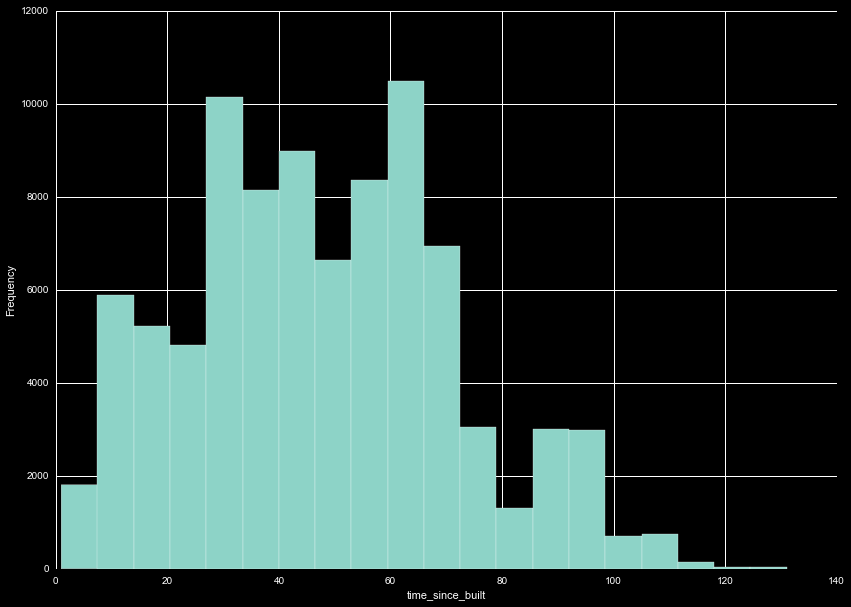

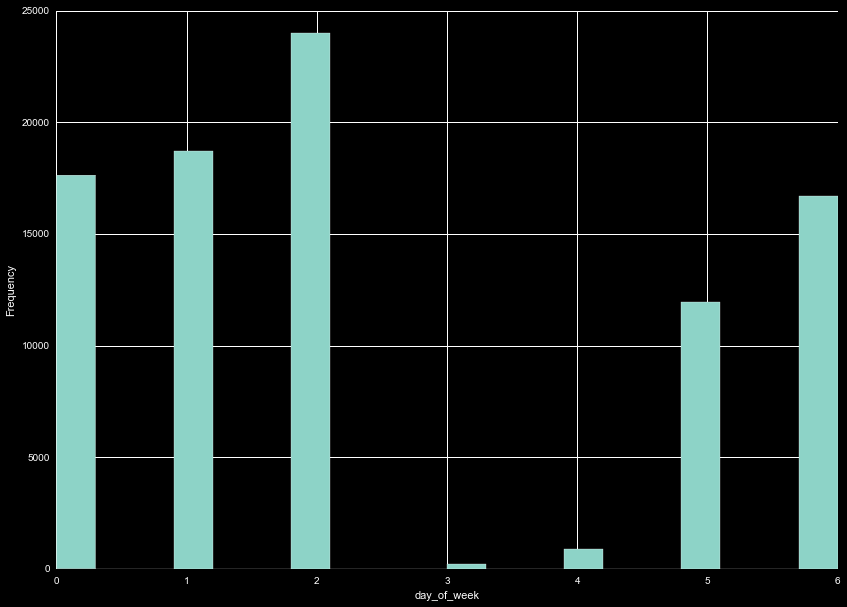

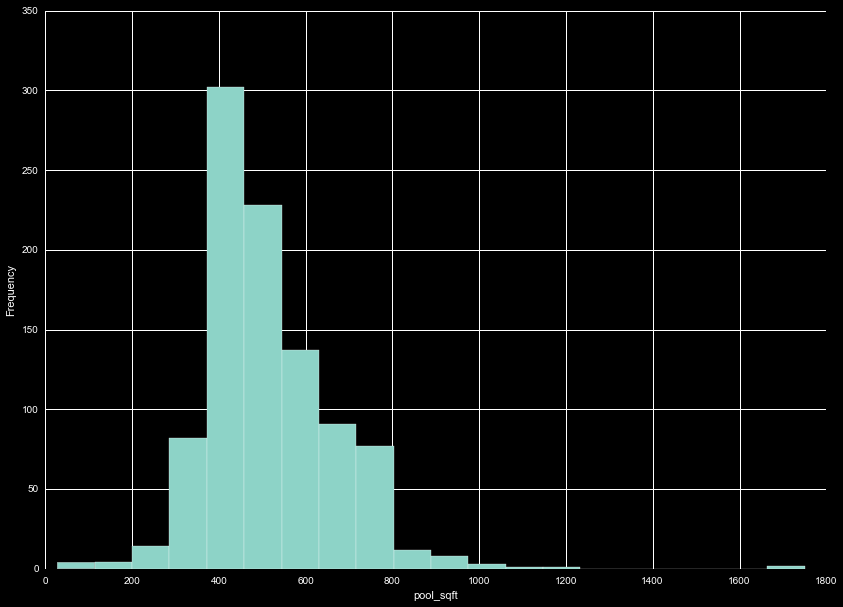

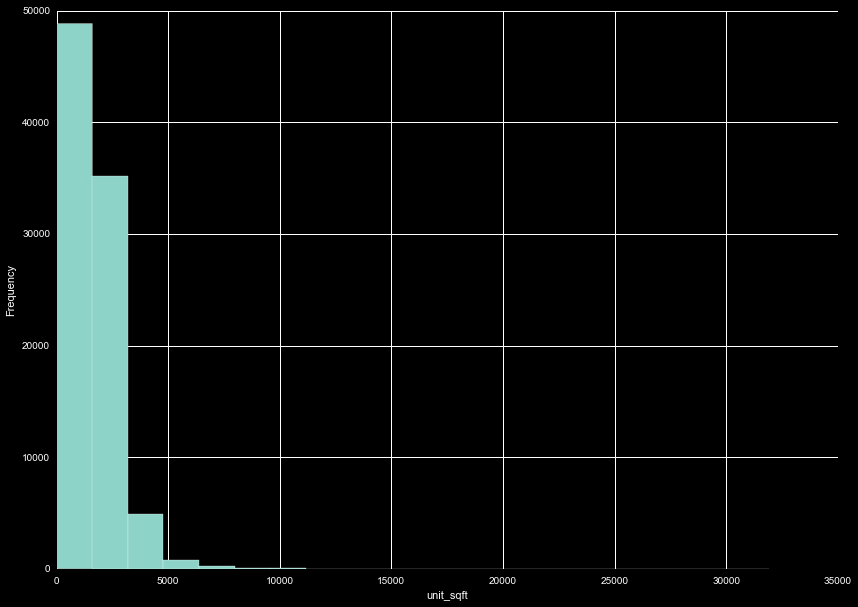

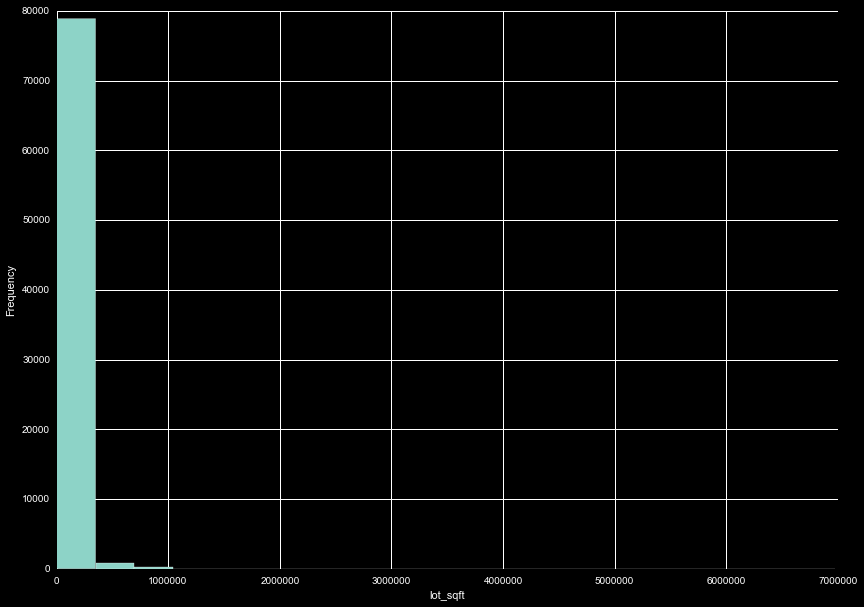

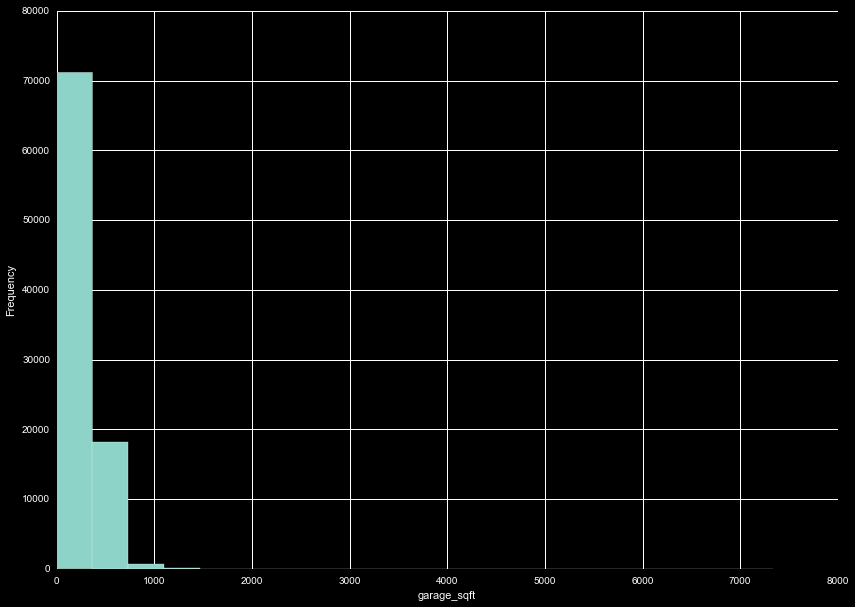

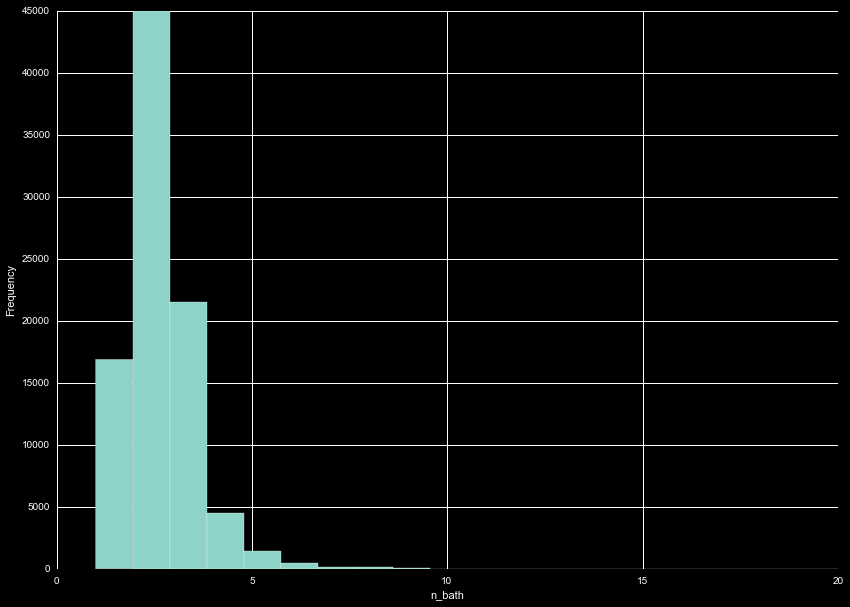

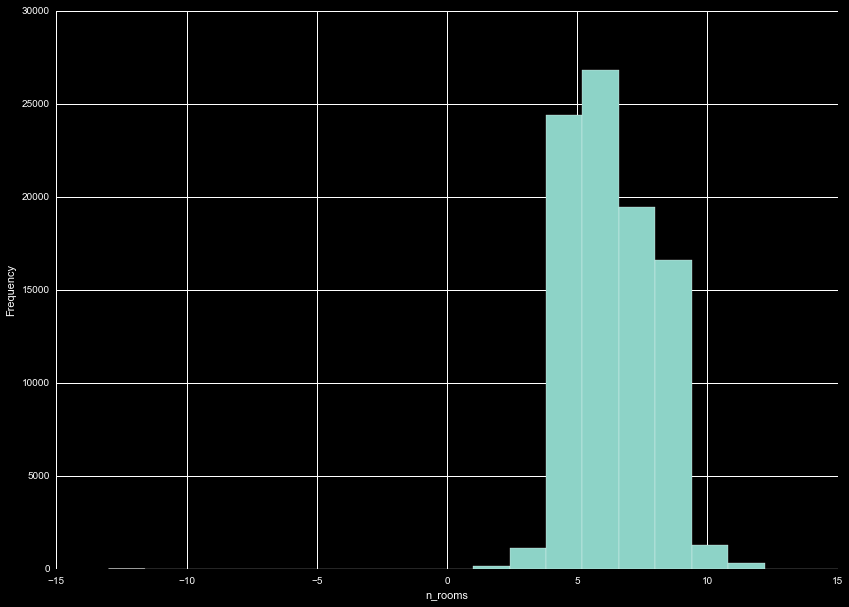

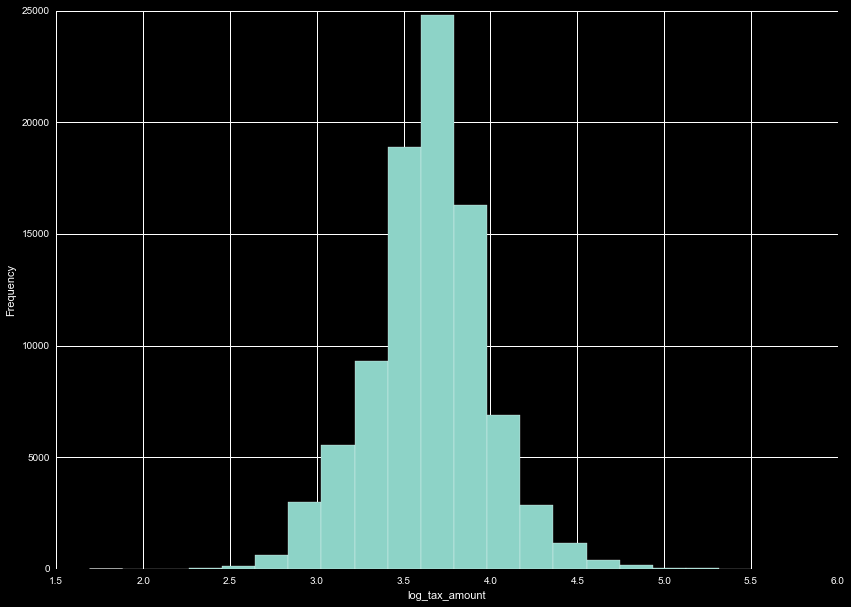

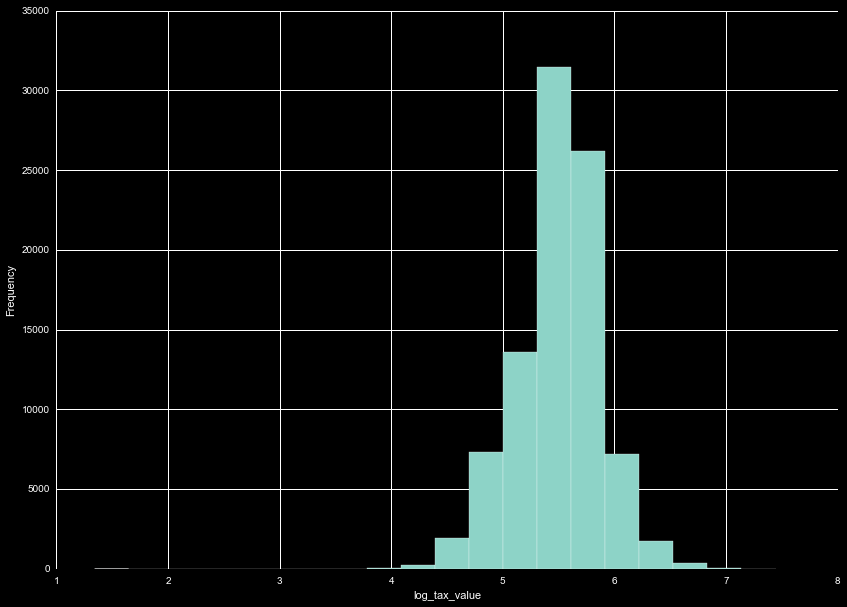

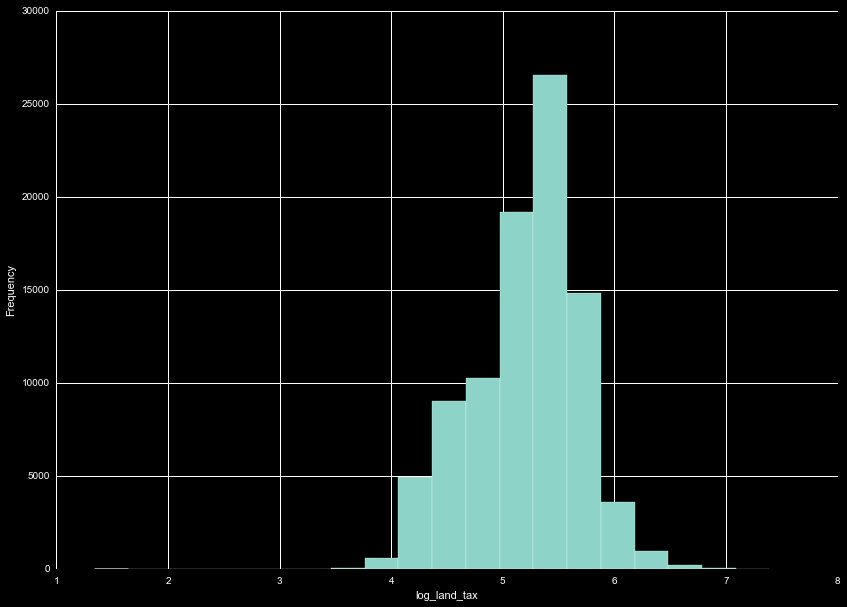

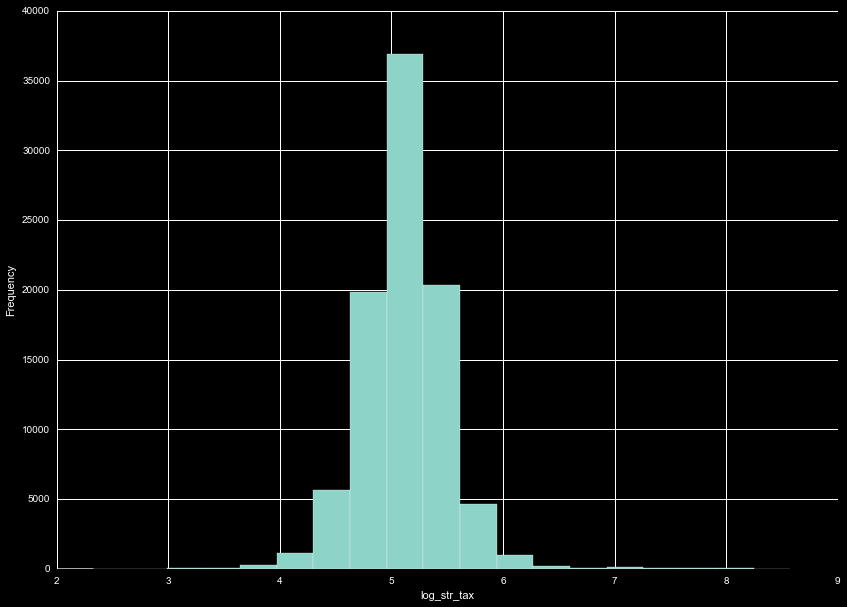

In [10]:
for item in cont_vars:
    my_df[item].plot.hist( bins=20 )
    plt.xlabel(item)
    plt.show()

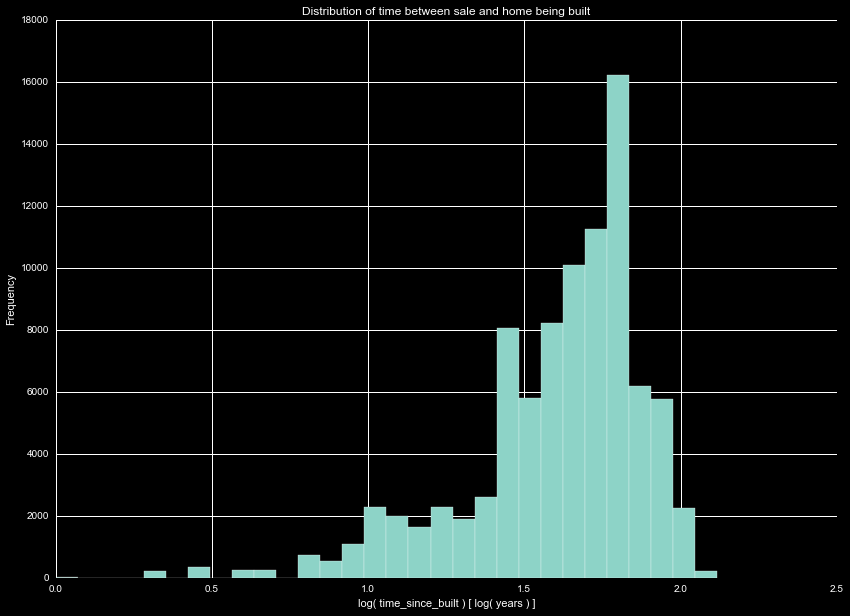

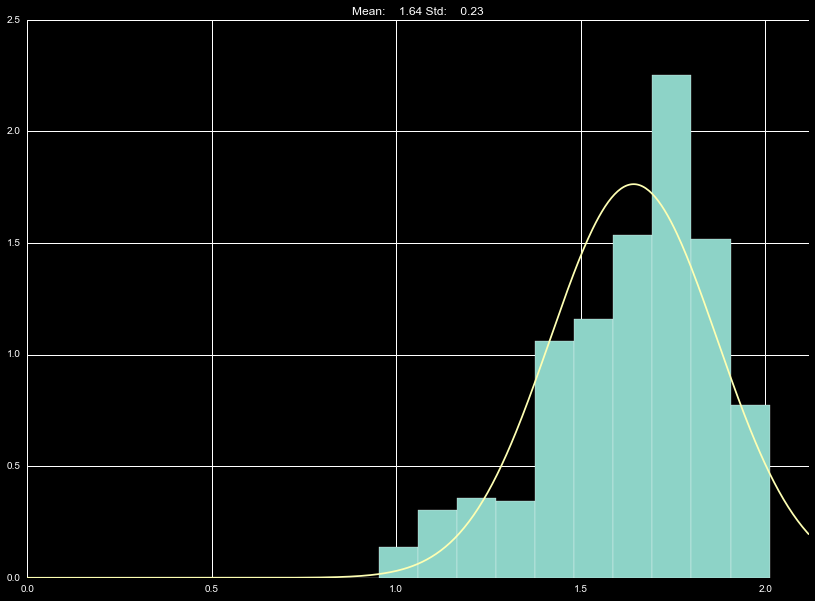

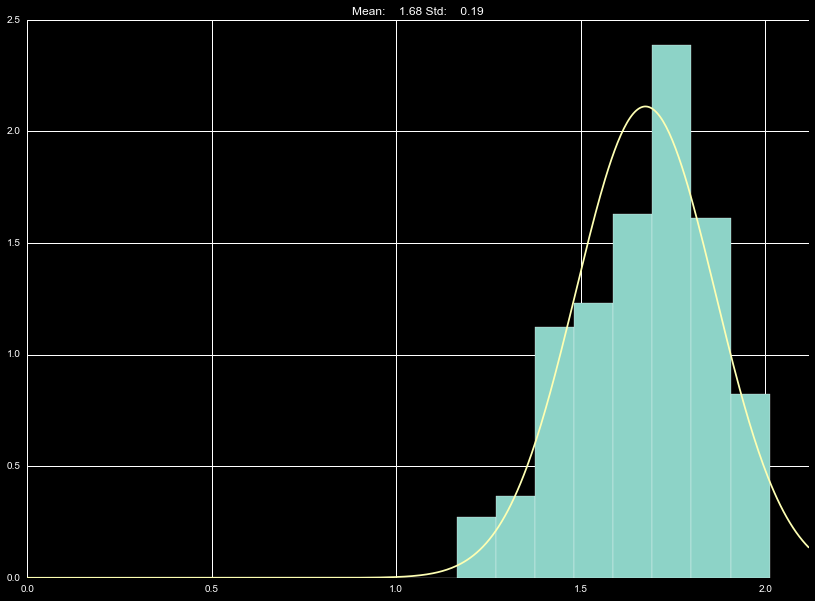

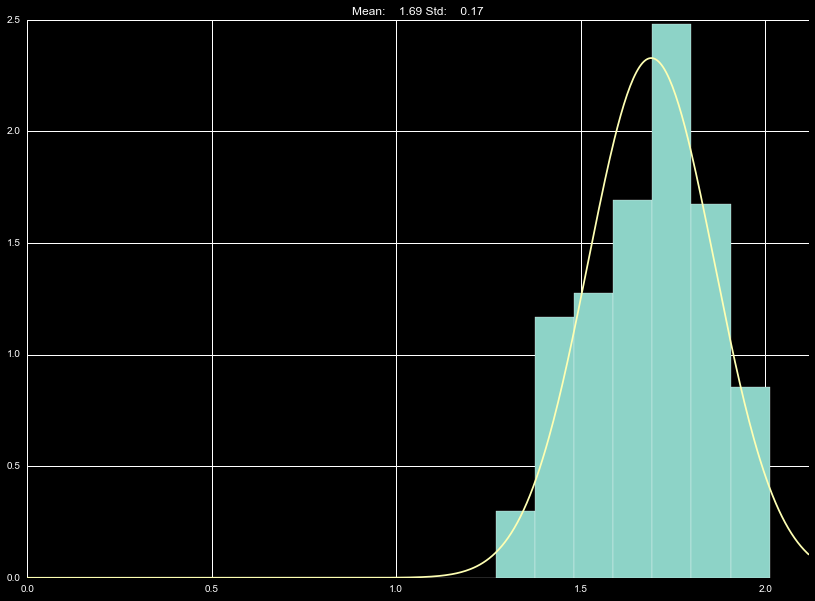

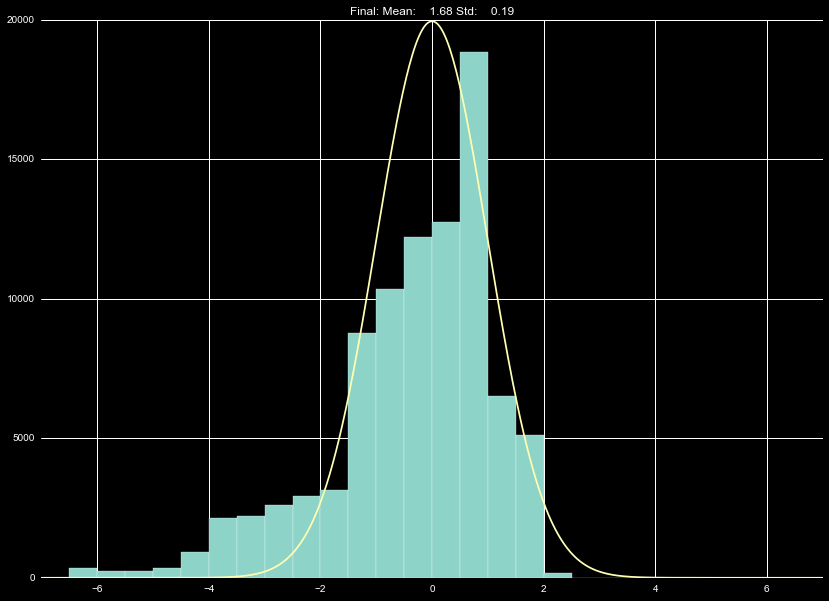

In [39]:
# Age

var_name = 'time_since_built'

np.log10( my_df[var_name] ).plot.hist( bins=30 )
plt.xlabel( 'log( '+var_name+' ) [ log( years ) ]' )
plt.title( 'Distribution of time between sale and home being built' )
plt.show()

my_df['log_age'] = np.log10( my_df[ var_name ] )

my_df['log_age_scaled'] = rv.smart_scale( my_df, column='log_age', n_sigma=2.0, show_final=True, curve_boost=5e4 )

my_df = my_df.drop( ['time_since_built','log_age'], axis=1 )

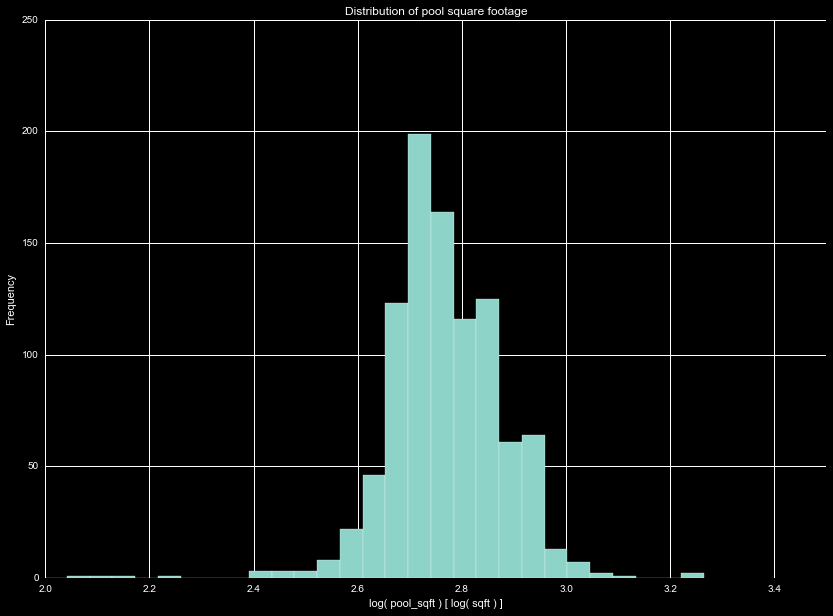

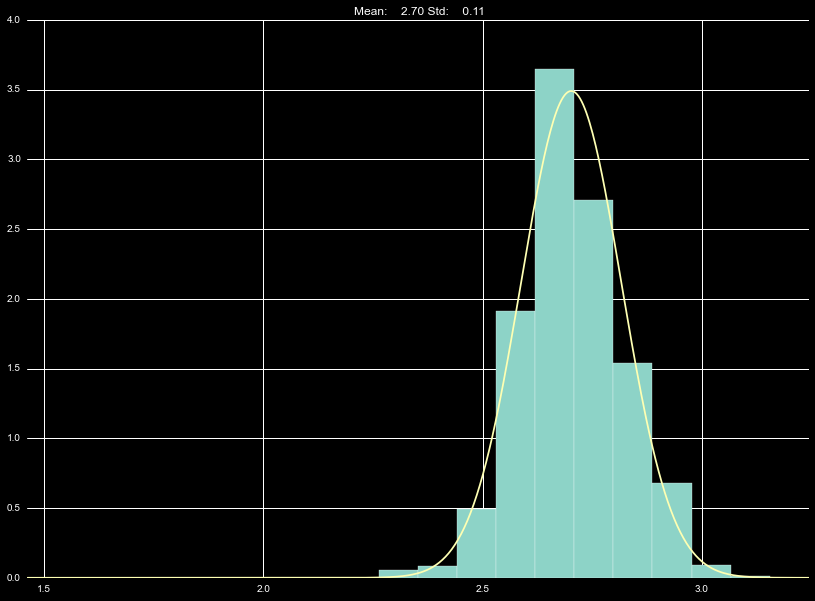

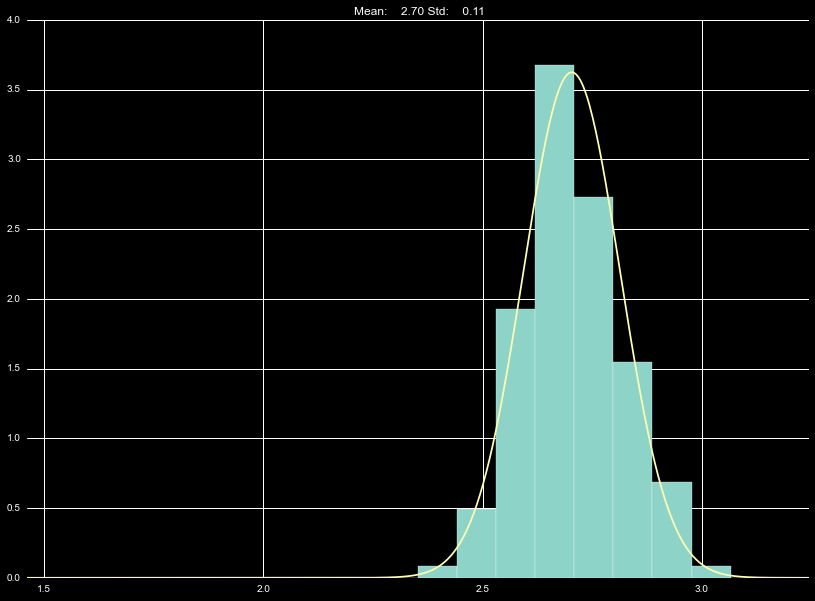

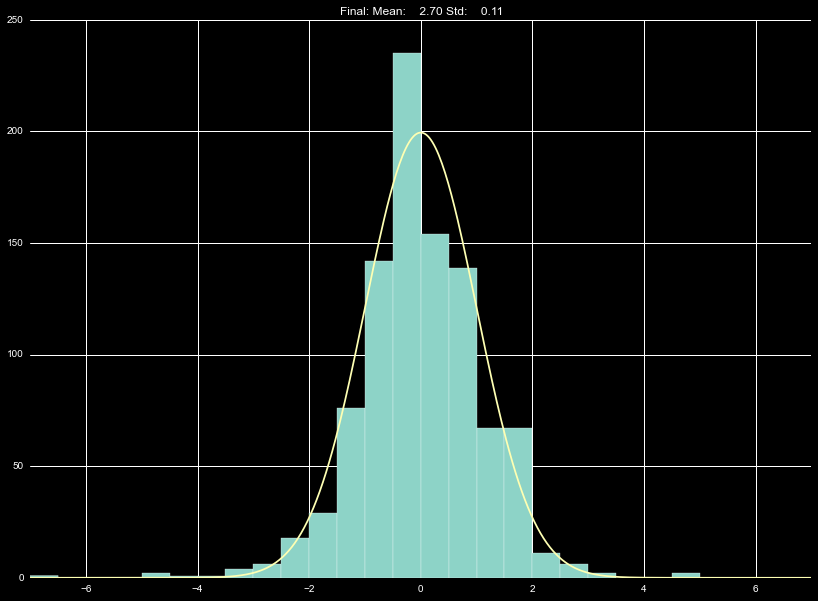

In [54]:
# pool_sqft

var_name = 'pool_sqft'

np.log10( my_df[var_name]+90 ).plot.hist( bins=30 )
plt.xlim([2,3.5])
plt.ylim([0,2.5e2])
plt.xlabel( 'log( '+var_name+' ) [ log( sqft ) ]' )
plt.title( 'Distribution of pool square footage' )
plt.show()

my_df['log_'+var_name          ] = np.log10( my_df[ var_name ]+1 )
my_df['log_'+var_name+'_scaled'] = 0

foo = my_df.ix[ my_df['log_'+var_name]>0, 'log_'+var_name].to_frame().copy()

my_df.ix[my_df['log_'+var_name]>0,'log_'+var_name+'_scaled'] = \
    rv.smart_scale( foo, column='log_'+var_name, n_sigma=3.0, show_final=True, curve_boost=5e2 )
    
my_df = my_df.drop( ['pool_sqft','log_pool_sqft'], axis=1 )

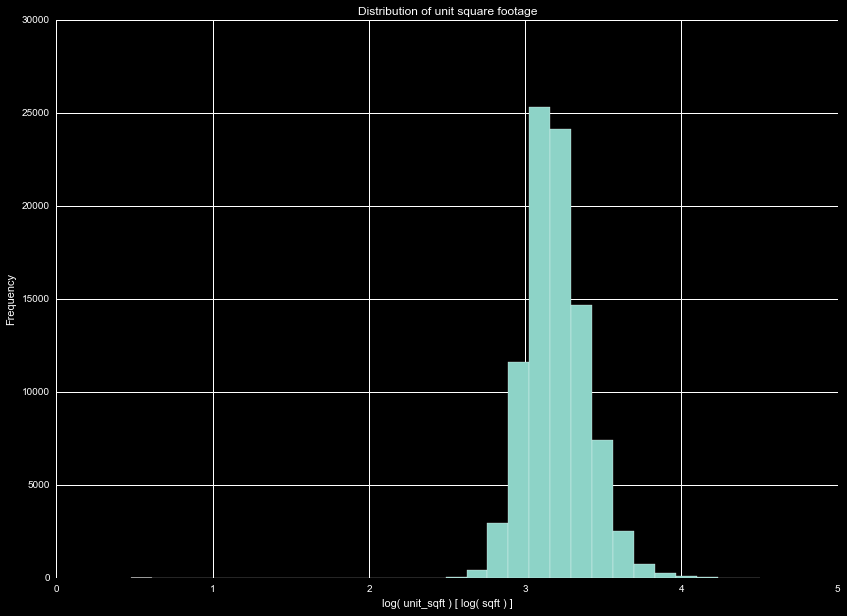

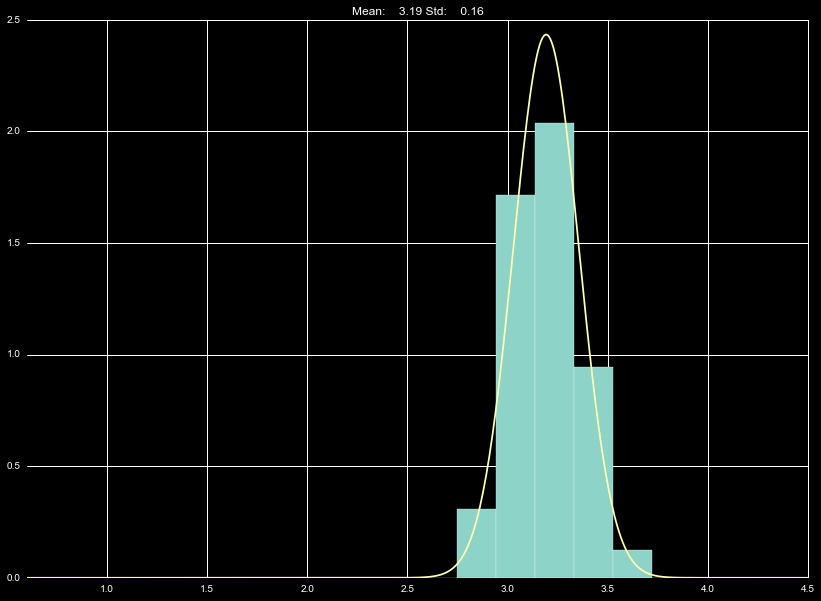

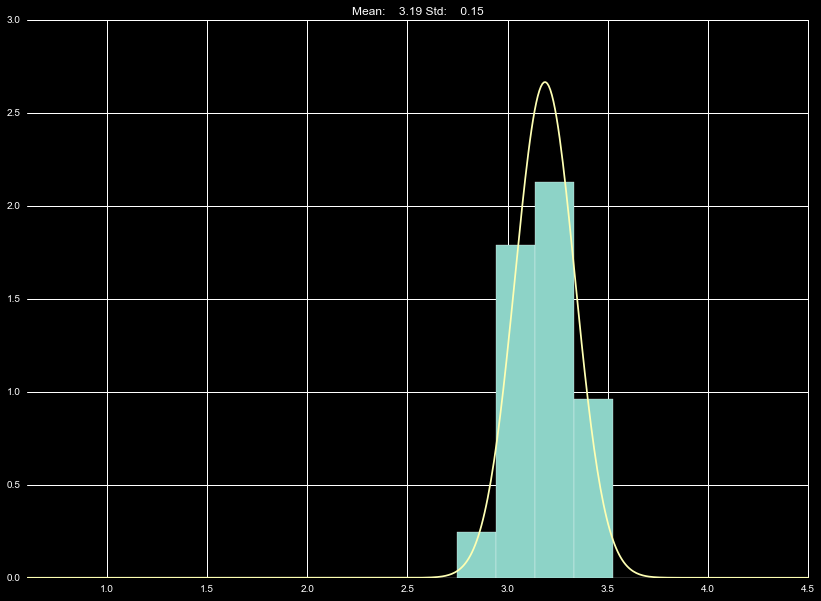

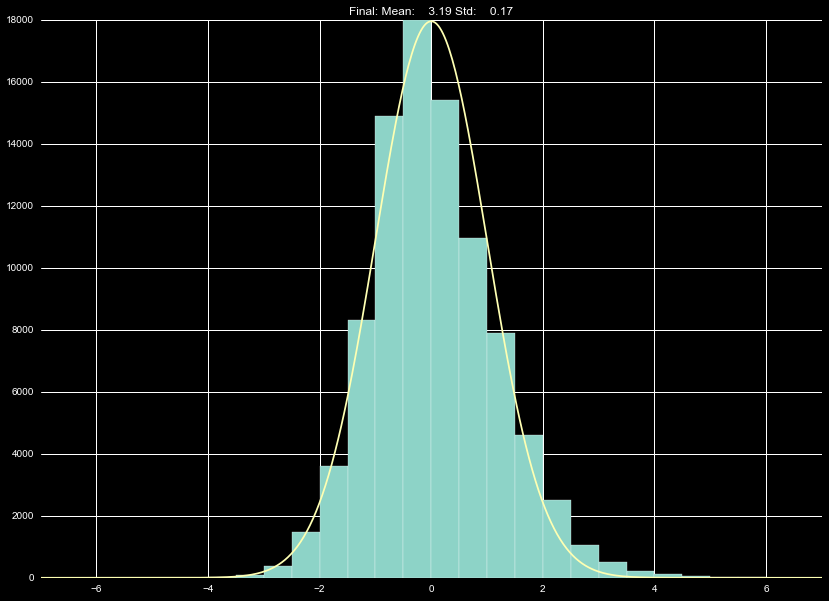

In [62]:
# unit_sqft

var_name = 'unit_sqft'

np.log10( my_df[var_name] ).plot.hist( bins=30 )
plt.xlabel( 'log( '+var_name+' ) [ log( sqft ) ]' )
plt.title( 'Distribution of unit square footage' )
plt.show()

my_df['log_'+var_name          ] = np.log10( my_df[ var_name ]+1 )

my_df['log_'+var_name+'_scaled'] = rv.smart_scale( my_df, column='log_'+var_name, n_sigma=2.0, show_final=True, curve_boost=4.5e4 )

my_df = my_df.drop( ['unit_sqft','log_unit_sqft'], axis=1 )

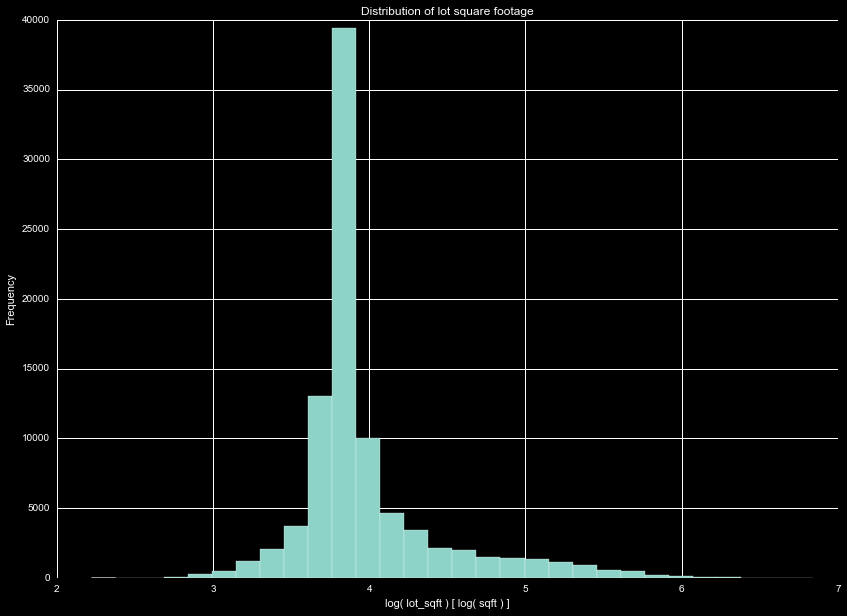

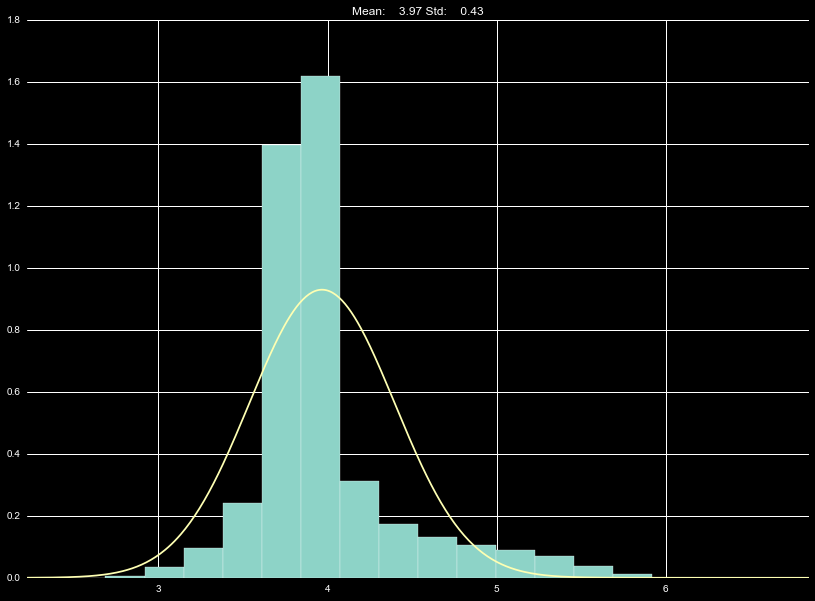

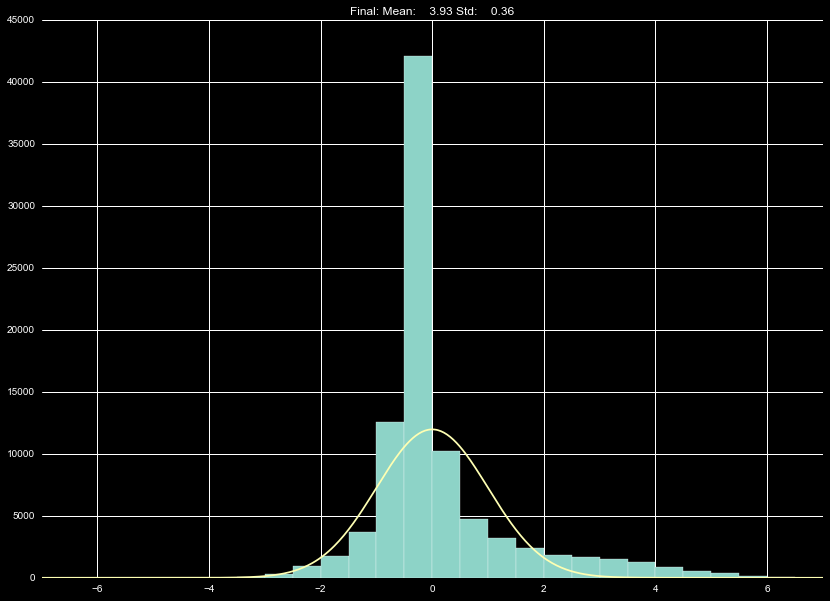

In [72]:
# lot_sqft

var_name = 'lot_sqft'

np.log10( my_df[var_name] ).plot.hist( bins=30 )
plt.xlabel( 'log( '+var_name+' ) [ log( sqft ) ]' )
plt.title( 'Distribution of lot square footage' )
plt.show()

my_df['log_'+var_name          ] = np.log10( my_df[ var_name ]+1 )

my_df['log_'+var_name+'_scaled'] = rv.smart_scale( my_df, column='log_'+var_name, n_sigma=4.0, show_final=True, curve_boost=3e4 )

my_df = my_df.drop( ['lot_sqft','log_lot_sqft'], axis=1 )

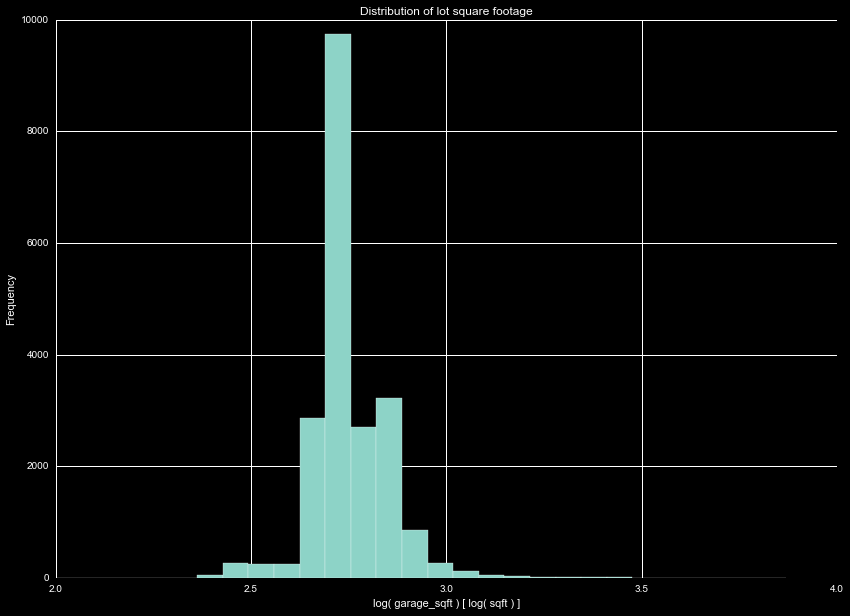

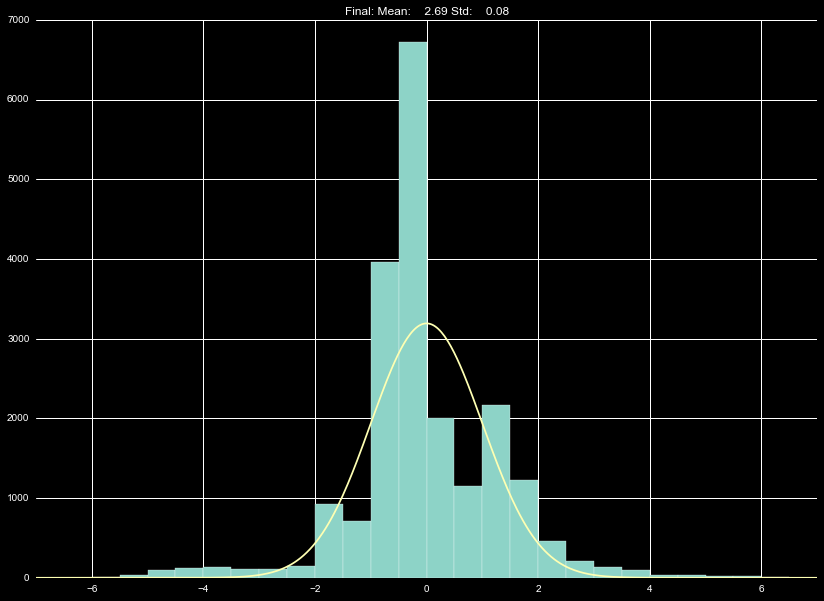

In [88]:
# garage_sqft

var_name = 'garage_sqft'

np.log10( my_df[var_name]+80 ).plot.hist( bins=30 )
plt.xlim(2,4)
plt.ylim(0,1e4)
plt.xlabel( 'log( '+var_name+' ) [ log( sqft ) ]' )
plt.title( 'Distribution of lot square footage' )
plt.show()

my_df['log_'+var_name          ] = np.log10( my_df[ var_name ]+1 )
my_df['log_'+var_name+'_scaled'] = 0

foo = my_df.ix[ my_df['log_'+var_name]>0, 'log_'+var_name].to_frame().copy()

my_df.ix[my_df['log_'+var_name]>0,'log_'+var_name+'_scaled'] = \
    rv.smart_scale( foo, column='log_'+var_name, n_sigma=3.0, show_final=True, curve_boost=8e3 )
    
my_df = my_df.drop( ['garage_sqft','log_garage_sqft'], axis=1 )

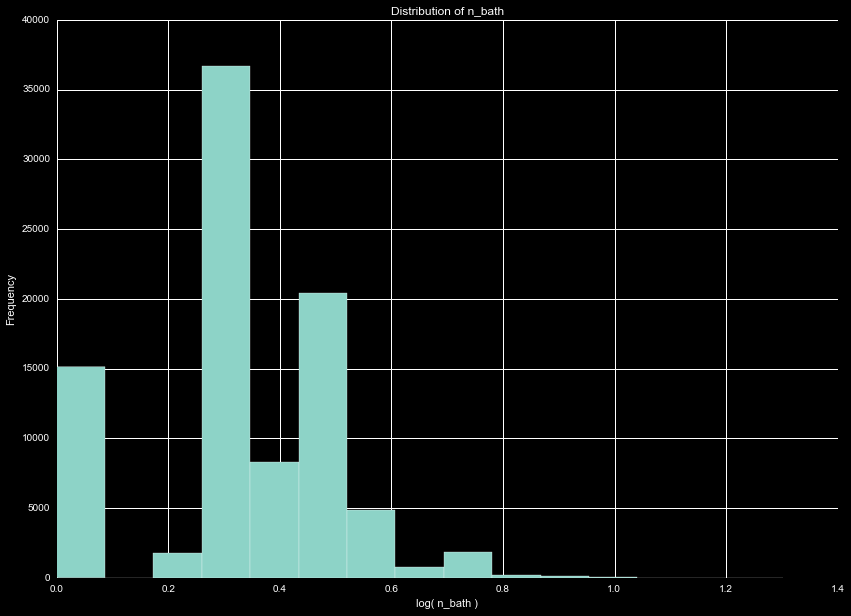

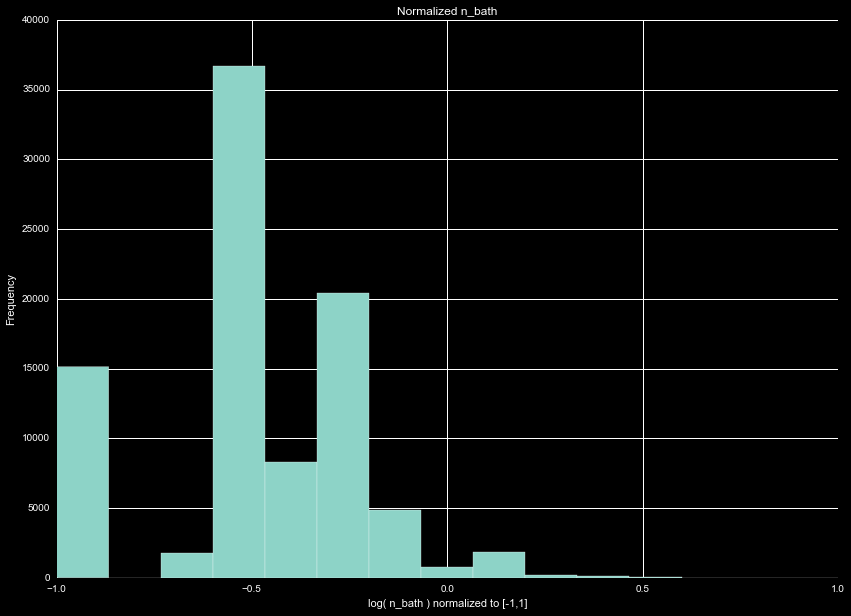

In [99]:
# n_bath

var_name = 'n_bath'

np.log10( my_df[var_name] ).plot.hist( bins=15 )
plt.xlabel( 'log( n_bath )' )
plt.title( 'Distribution of n_bath' )
plt.show()

my_df['log_'+var_name          ] = np.log10( my_df[ var_name ] )

my_df['log_'+var_name+'_norm'] = rv.normalize_column( inp_df=my_df, column='log_'+var_name )


my_df['log_'+var_name+'_norm'].plot.hist( bins=15 )
plt.xlabel( 'log( n_bath ) normalized to [-1,1]' )
plt.title( 'Normalized n_bath' )
plt.show()

my_df = my_df.drop( ['n_bath','log_n_bath'], axis=1 )

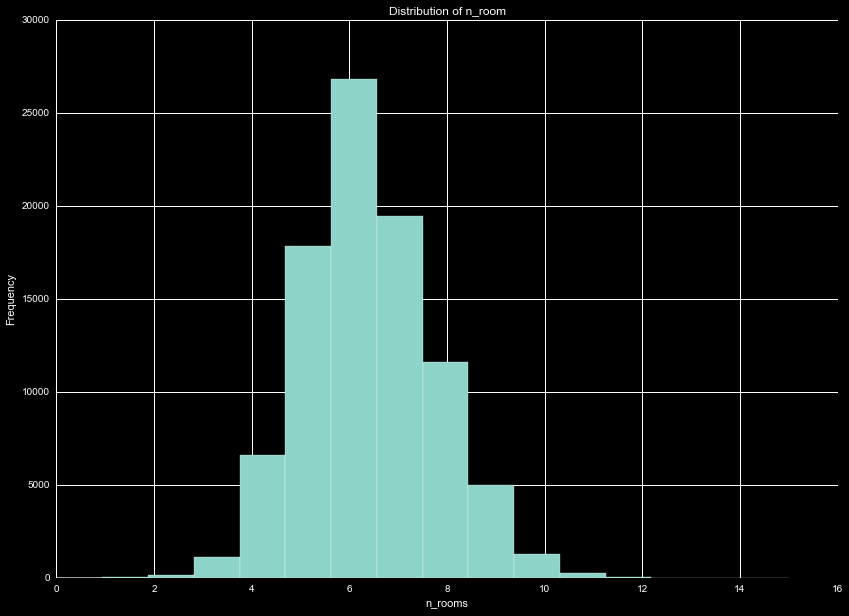

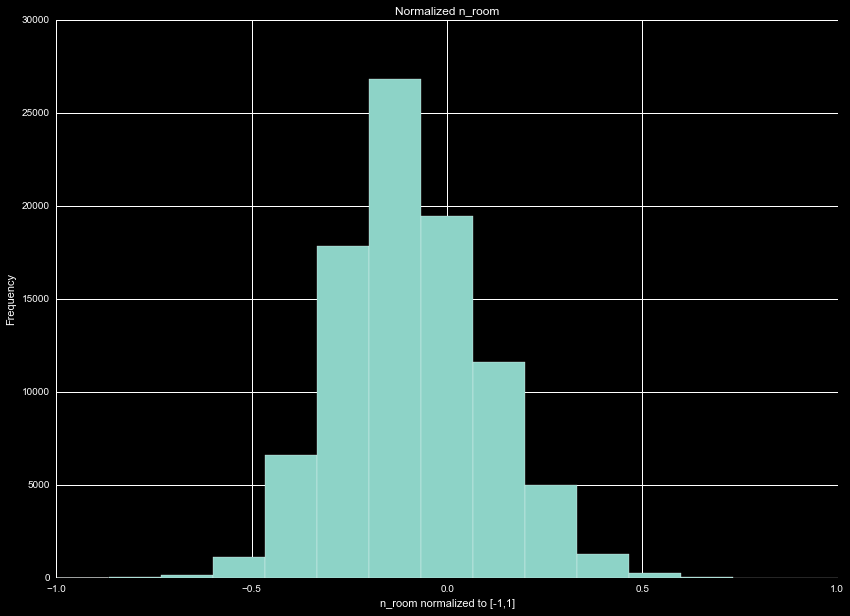

In [111]:
# n_baths

var_name = 'n_rooms'

my_df[var_name].plot.hist( bins=16 )
plt.xlabel( 'n_rooms' )
plt.title( 'Distribution of n_room' )
plt.show()


my_df[var_name+'_norm'] = rv.normalize_column( inp_df=my_df, column=var_name )


my_df[var_name+'_norm'].plot.hist( bins=15 )
plt.xlabel( 'n_room normalized to [-1,1]' )
plt.title( 'Normalized n_room' )
plt.show()

my_df = my_df.drop( ['n_rooms'], axis=1 )

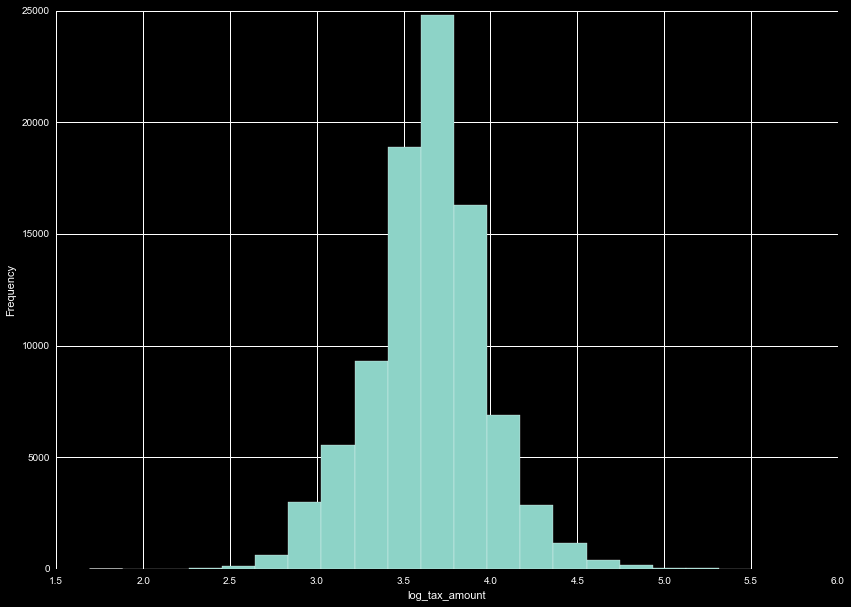

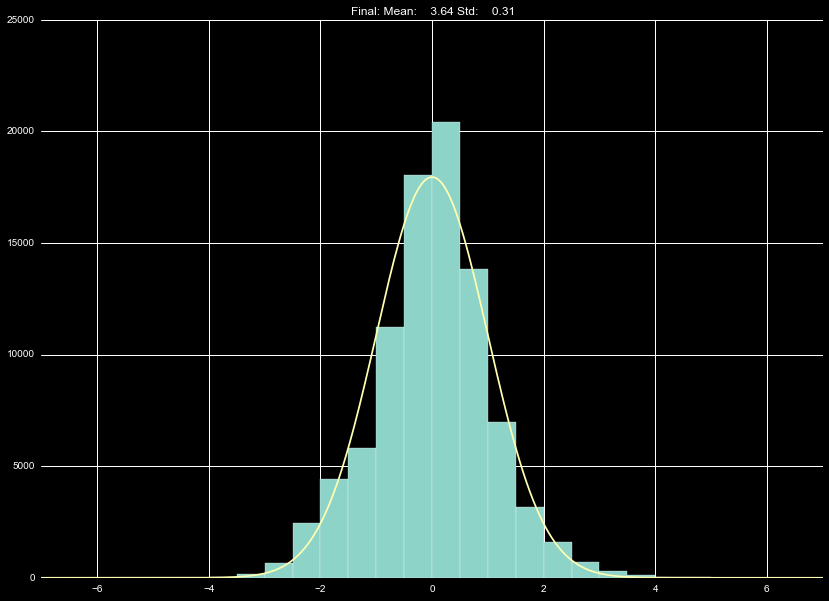

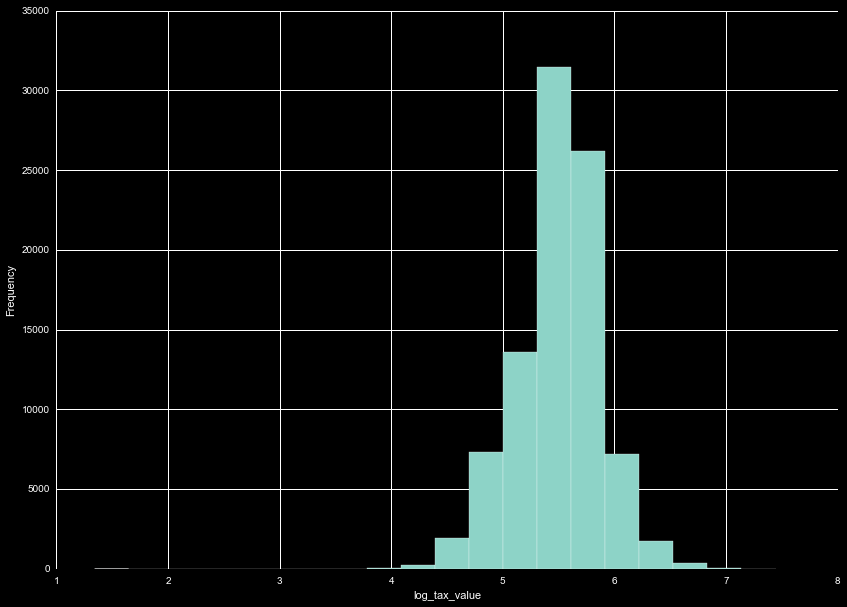

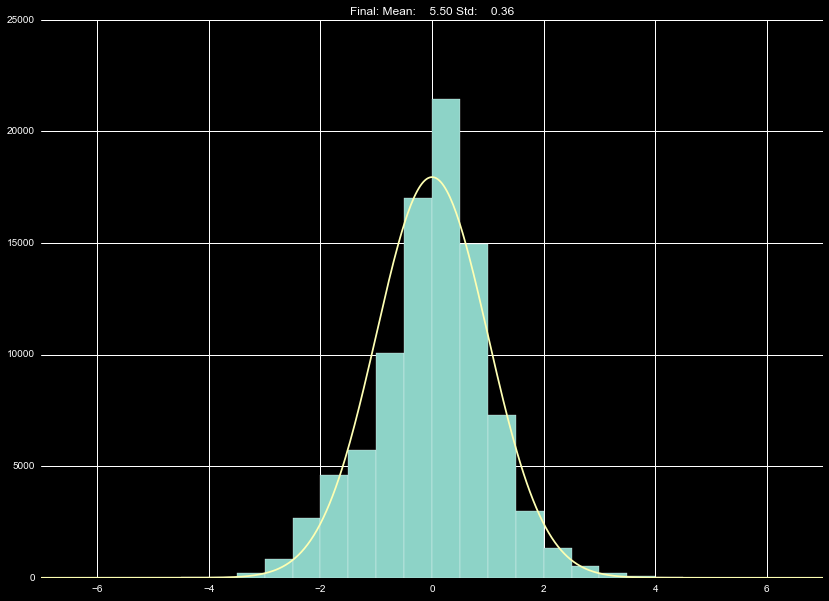

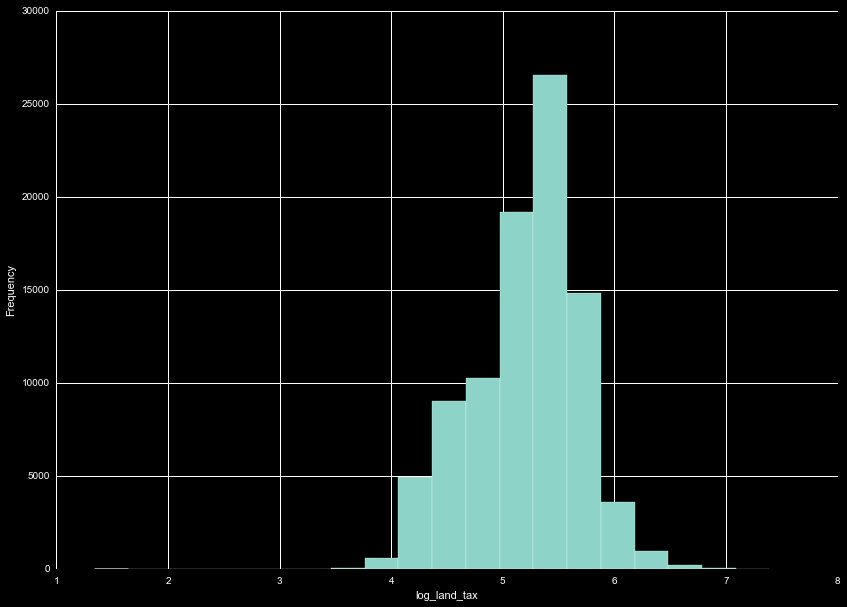

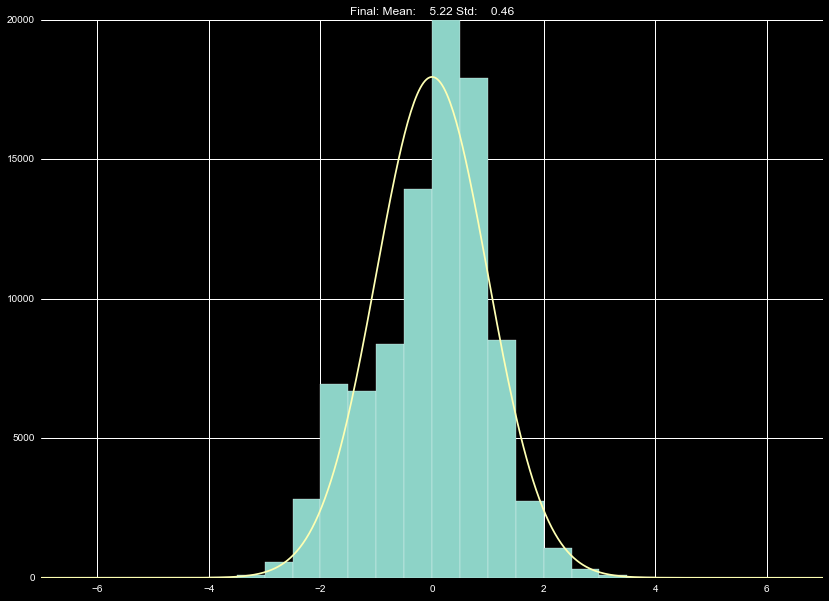

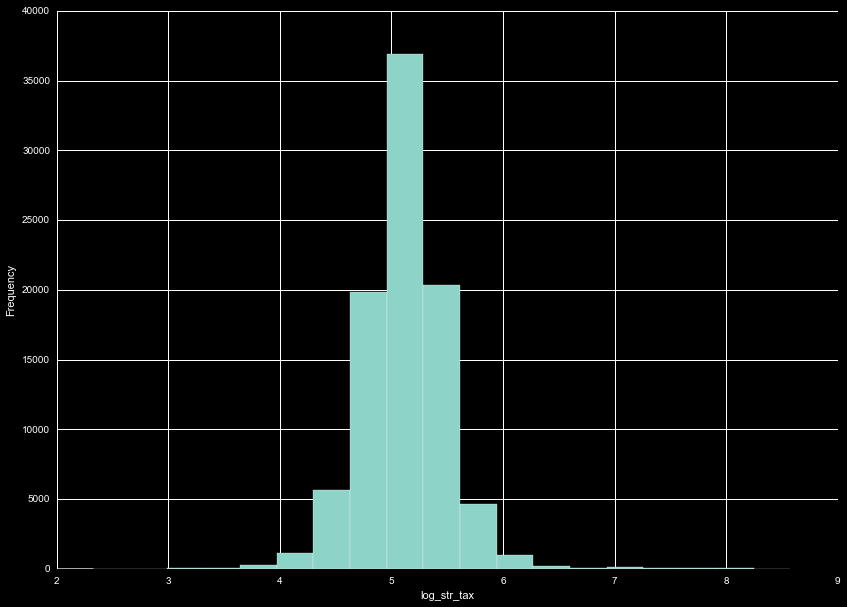

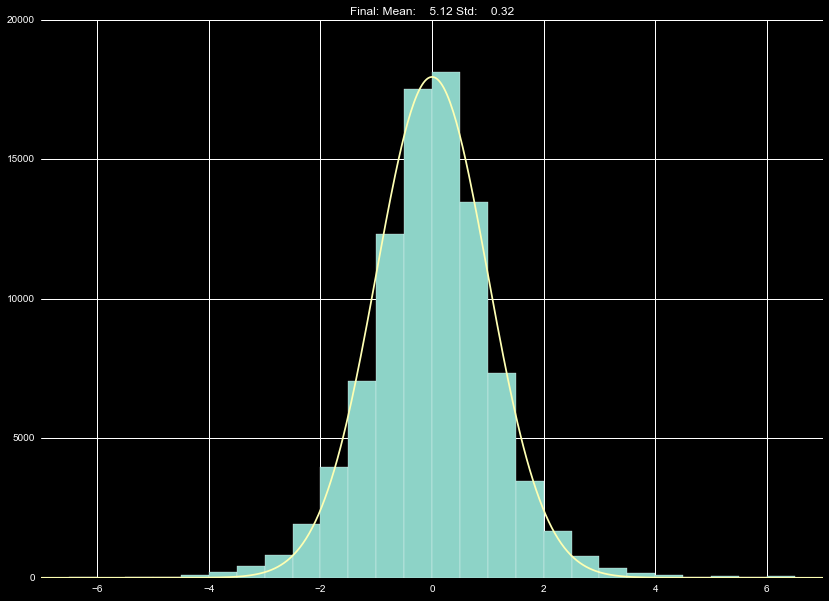

In [126]:
for item, sig in zip( ['log_tax_amount', 'log_tax_value', 'log_land_tax', 'log_str_tax'], [3.0,3.0,2.0,2.5] ):
    my_df[item].plot.hist( bins=20 )
    plt.xlabel(item)
    plt.show()
    
    my_df[item+'_scaled'] = rv.smart_scale( my_df, column=item, n_sigma=sig, show_final=True, curve_boost=4.5e4 )
    
    print ' '
    print ' '

In [132]:
# Use PCA on tax dollar values, 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount'
# [ 0.82876496  0.12993589  0.03434282  0.00695633]
tax_pca = PCA( n_components=2 )
tax_pca.fit( my_df[['log_tax_amount_scaled','log_tax_value_scaled','log_land_tax_scaled','log_str_tax_scaled']] )
print tax_pca.explained_variance_ratio_

foo = tax_pca.transform( my_df[['log_tax_amount_scaled','log_tax_value_scaled','log_land_tax_scaled','log_str_tax_scaled']] )
my_df['tax_pca_0'] = foo[:,0]
my_df['tax_pca_1'] = foo[:,1]

my_df = my_df.drop( ['log_tax_amount_scaled','log_tax_value_scaled','log_land_tax_scaled','log_str_tax_scaled',
                     'log_tax_amount', 'log_tax_value', 'log_land_tax', 'log_str_tax' ], axis=1 )

[ 0.82876496  0.12993589]


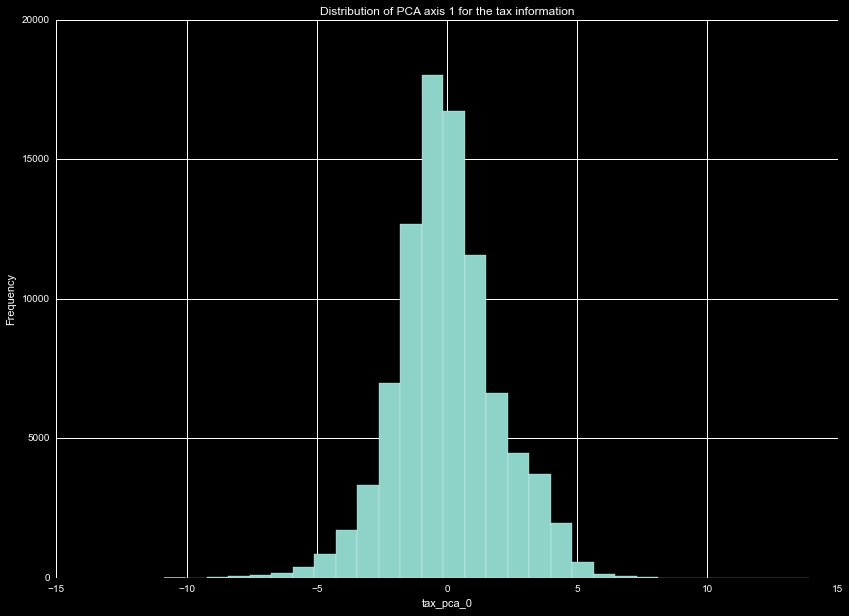

In [139]:
my_df['tax_pca_0'].plot.hist(bins=30)
plt.xlabel( 'tax_pca_0' )
plt.title( 'Distribution of PCA axis 1 for the tax information' )
plt.show()

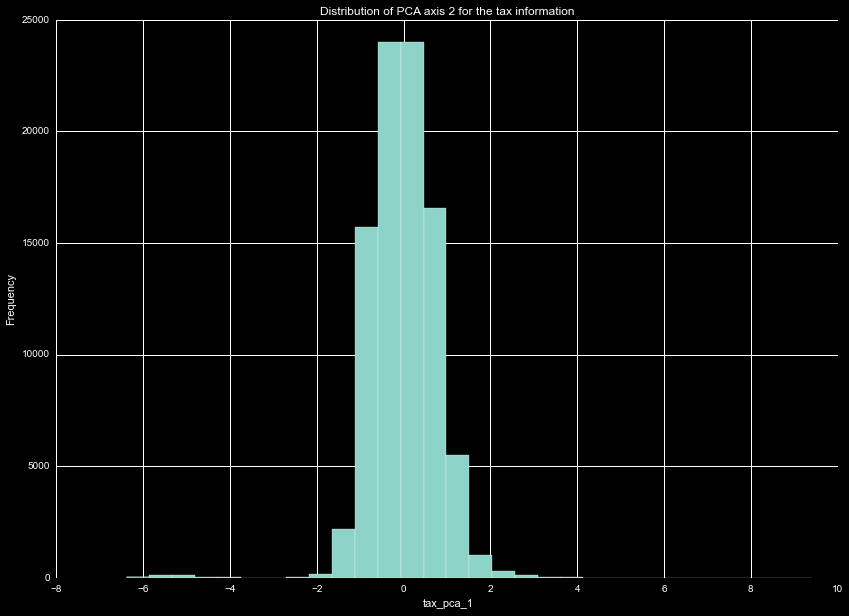

In [140]:
my_df['tax_pca_1'].plot.hist(bins=30)
plt.xlabel( 'tax_pca_1' )
plt.title( 'Distribution of PCA axis 2 for the tax information' )
plt.show()

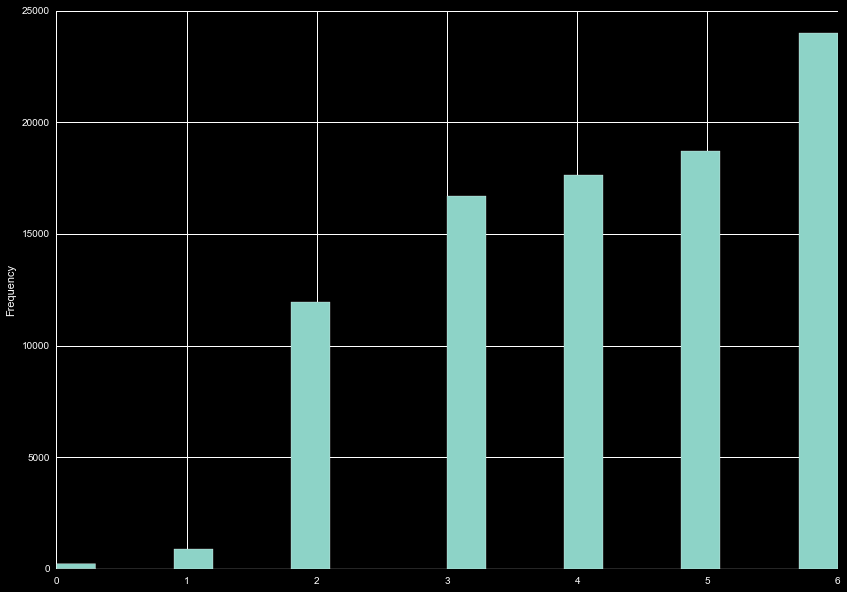

In [144]:
((my_df['day_of_week']+4)%7).plot.hist(bins=20)

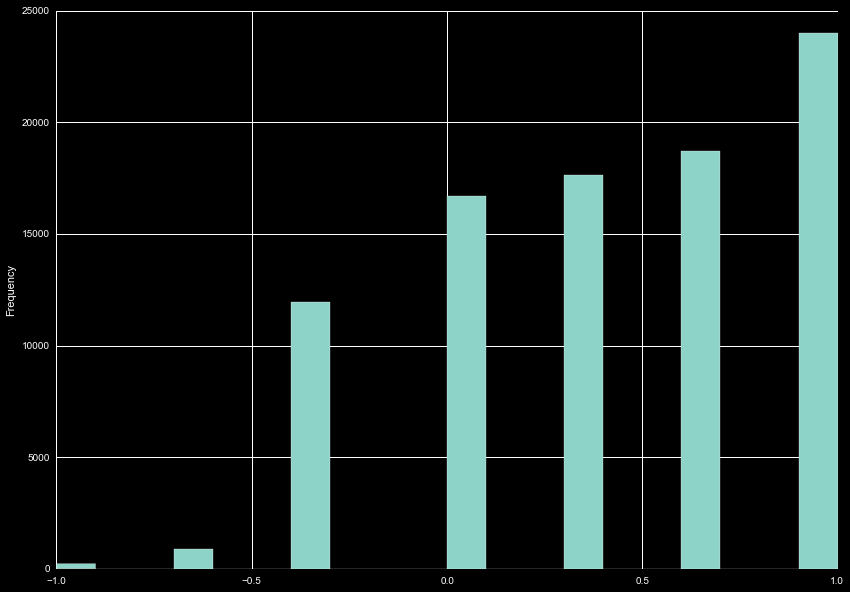

In [148]:
my_df['new_day_of_week'] = ( ((my_df['day_of_week']+4)%7) - 3 ) / 3
my_df['new_day_of_week'].plot.hist( bins=20 )

In [149]:
my_df['day_of_week'] = ( ((my_df['day_of_week']+4)%7) - 3 ) / 3

In [151]:
my_df.columns.values

array(['parcelid', 'logerror', 'time_since_built', 'day_of_week', 'has_ac',
       'has_spa', 'has_pool', 'pool_sqft', 'unit_sqft', 'lot_sqft',
       'unit_single', 'unit_double', 'unit_multi', 'tax_delinquent',
       'building_quality_low', 'building_quality_med',
       'building_quality_high', 'building_quality_unkn', 'has_garage',
       'garage_sqft', 'story_single', 'story_multi', 'story_unkn',
       'has_deck', 'log_tax_amount', 'log_tax_value', 'log_land_tax',
       'log_str_tax', 'n_bath', 'n_rooms', 'log_age', 'log_age_scaled',
       'log_pool_sqft', 'log_pool_sqft_scaled', 'log_unit_sqft',
       'log_unit_sqft_scaled', 'log_lot_sqft', 'log_lot_sqft_scaled',
       'log_garage_sqft', 'log_garage_sqft_scaled', 'log_n_bath',
       'log_n_bath_scaled', 'log_n_bath_norm', 'log_n_rooms',
       'log_n_rooms_norm', 'n_rooms_norm', 'log_tax_amount_scaled',
       'log_tax_value_scaled', 'log_land_tax_scaled', 'log_str_tax_scaled',
       'tax_pca_0', 'tax_pca_1', 'new_day_of_